<a href="https://colab.research.google.com/github/Mervvick/AI_Basketball_prediction/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

На базе баскетбольных матчей добейтесь средней абсолютной ошибки 17 и менее очков.

### Подготовка  

In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, LambdaCallback
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

In [ ]:
# Загрузка из google облака
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

# Библиотека для работы с базами
import pandas as pd
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
df.head()

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0


Извлекаем текстовые данные из колонки `info` таблицы, помещаем в переменную `data_text`. Выводим длину списка:

In [ ]:
data_text = df['info'].values
len(data_text)

52450

Задаем максимальное кол-во слов в словаре, помещаем в переменную все символы, которые хотим вычистить из текста.

 Токенизируем текстовые данные:

In [ ]:
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)

In [ ]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

Преобразуем данные в numpy, подготовим наборы для обучения:

In [ ]:
# Библиотека работы с массивами
import numpy as np

xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xBOW_text.shape)

(52450, 5)
(52450,)
(52450, 5000)


In [ ]:
# Функция по проверке ошибки

def check_MAE_predictl_DubbleInput (model,
                                    x_data,
                                    x_data_text,
                                    y_data_not_scaled,
                                    plot=False):

  mae = 0 # Инициализируем начальное значение ошибки
  y_pred = (model.predict([x_data,x_data_text])).squeeze()

  for n in range (0,len(x_data)):
    mae += abs(y_data_not_scaled[n] - y_pred[n]) # Увеличиваем значение ошибки для текущего элемента
  mae /= len(x_data) # Считаем среднее значение
  print('Среднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/y_data_not_scaled.mean(axis=0))*100,len(x_data)))

  if plot:
     plt.scatter(y_data_not_scaled, y_pred)
     plt.xlabel('Правильные значение')
     plt.ylabel('Предсказания')
     plt.axis('equal')
     plt.xlim(plt.xlim())
     plt.ylim(plt.ylim())
     plt.plot([0, 250], [0, 250])
     plt.show()

Для решения задачи требуются знания по теме `Callbacks`, пожалуйста, изучите раздел:

---
Дополнителная информация: ([База знаний УИИ – **«Callbacks»**](https://colab.research.google.com/drive/1COE1R3kFhRlxPm9X6hQMvjKoiFFt83xW?usp=sharing))

---

In [ ]:
# ваше решение

In [ ]:
x_train, x_test, x_train_txt, x_test_txt, y_train, y_test = train_test_split(xTrain,
                                                                             xBOW_text,
                                                                             yTrain,
                                                                             test_size=0.05,
                                                                             shuffle=False,
                                                                             )

In [ ]:
input_num = Input(x_train.shape[1])
x1 = Dense(1000, activation = 'relu') (input_num)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.4) (x1)
x1 = Dense(500, activation = 'relu') (x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.3) (x1)
x1 = Dense(250, activation = 'sigmoid') (x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.3) (x1)

input_txt = Input(x_train_txt.shape[1])
x2 = Dense(400, activation = 'relu') (input_txt)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.4) (x2)
x2 = Dense(200, activation = 'relu') (x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.3) (x2)
x2 = Dense(100, activation = 'sigmoid') (x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.3) (x2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='sigmoid')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='linear')(x)

model = Model((input_num, input_txt), x)

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss='MAE',
              metrics=['mae']
              )

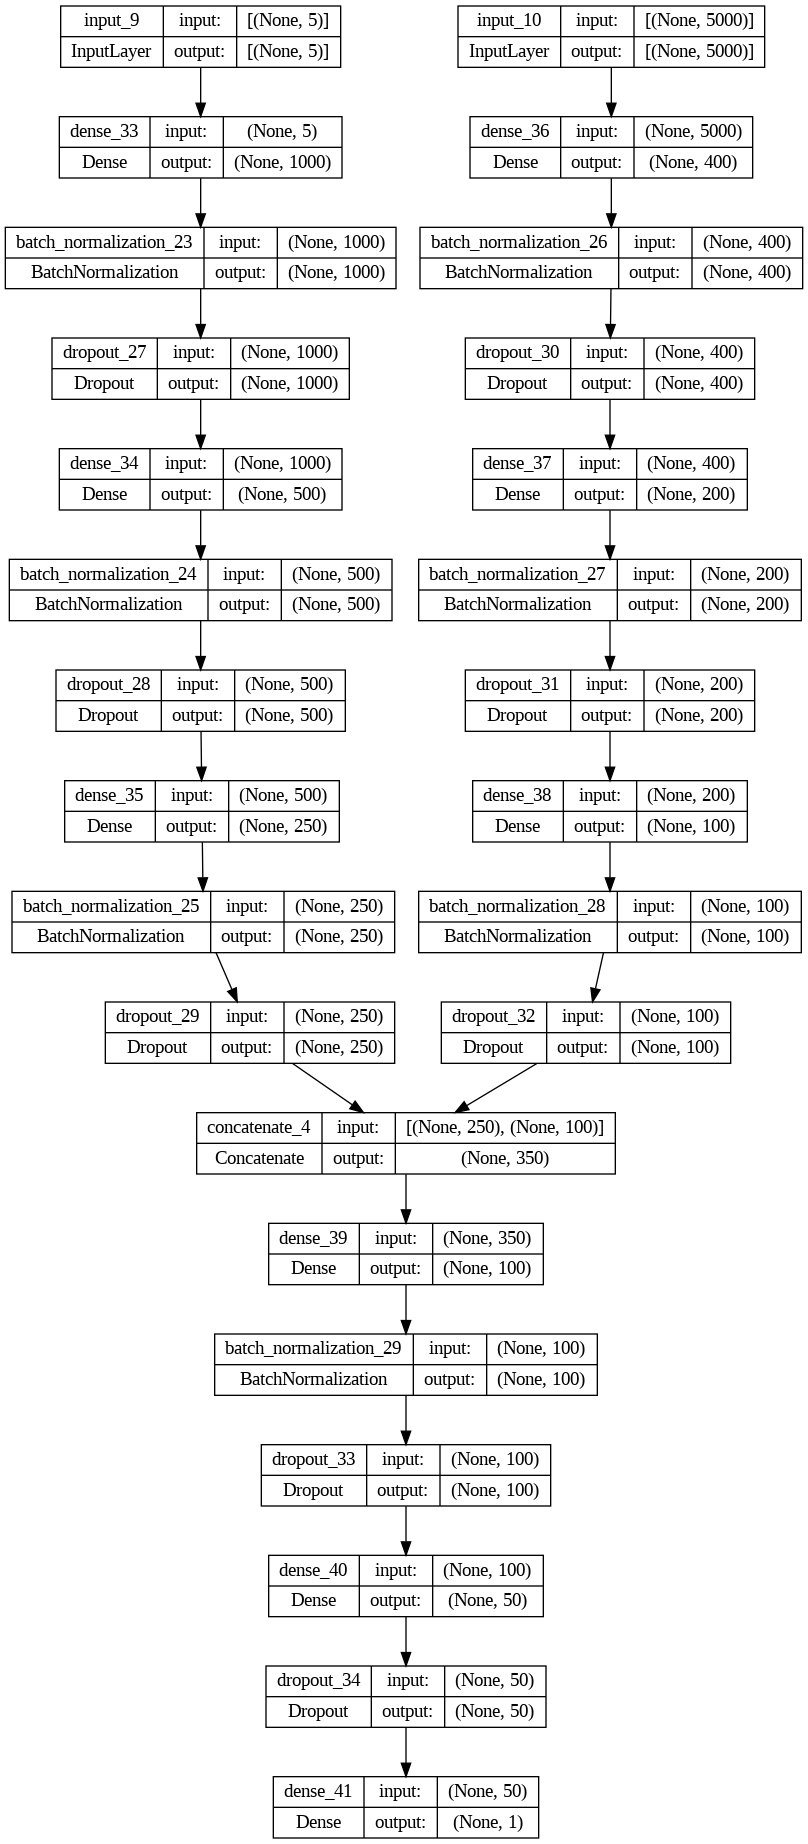

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
def on_epoch_end_custom(epoch, logs=None):
    check_MAE_predictl_DubbleInput(model,
                                   x_test,
                                   x_test_txt,
                                   y_test,
                                   plot=True
                                   )

In [ ]:
callback = LambdaCallback(on_epoch_end = on_epoch_end_custom)

In [ ]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                      factor = 0.2,
                                      patience = 2,
                                      verbose = 1)

Epoch 1/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 148.789 очков это 95.142% от общей выборки в 2623 игры


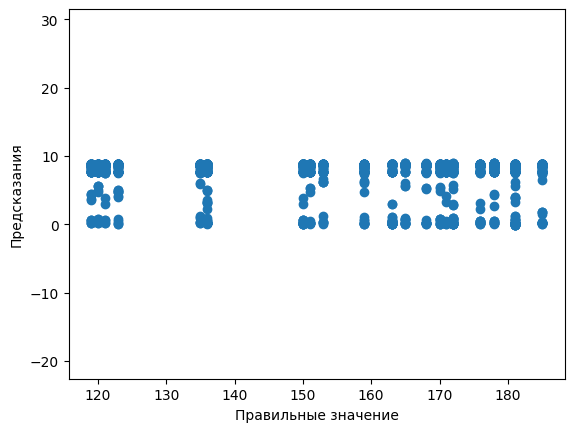

1324/1324 [==============================] - 25s 14ms/step - loss: 148.1819 - mae: 148.1819 - val_loss: 142.8115 - val_mae: 142.8115 - lr: 1.0000e-04
Epoch 2/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 141.219 очков это 90.300% от общей выборки в 2623 игры


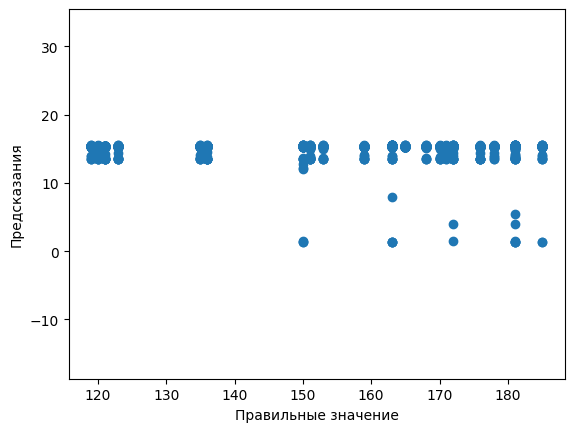

1324/1324 [==============================] - 17s 13ms/step - loss: 140.8884 - mae: 140.8884 - val_loss: 135.4625 - val_mae: 135.4625 - lr: 1.0000e-04
Epoch 3/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 134.397 очков это 85.939% от общей выборки в 2623 игры


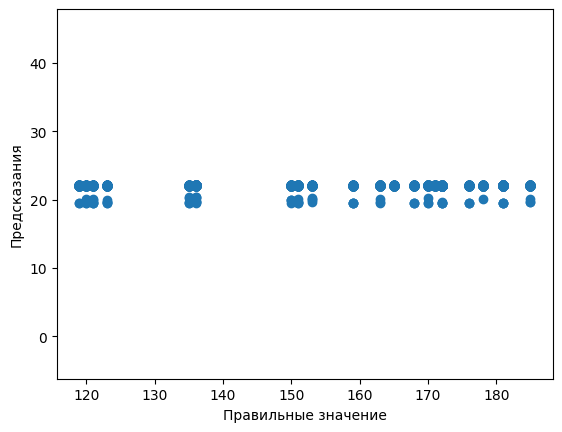

1324/1324 [==============================] - 17s 13ms/step - loss: 133.6832 - mae: 133.6832 - val_loss: 128.7036 - val_mae: 128.7036 - lr: 1.0000e-04
Epoch 4/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 127.490 очков это 81.522% от общей выборки в 2623 игры


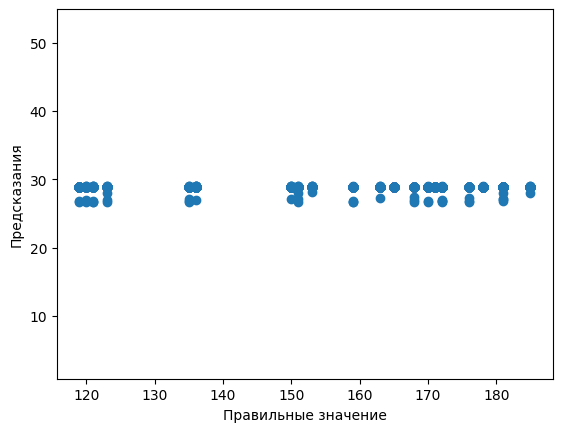

1324/1324 [==============================] - 19s 14ms/step - loss: 126.0678 - mae: 126.0678 - val_loss: 121.7881 - val_mae: 121.7881 - lr: 1.0000e-04
Epoch 5/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 120.946 очков это 77.337% от общей выборки в 2623 игры


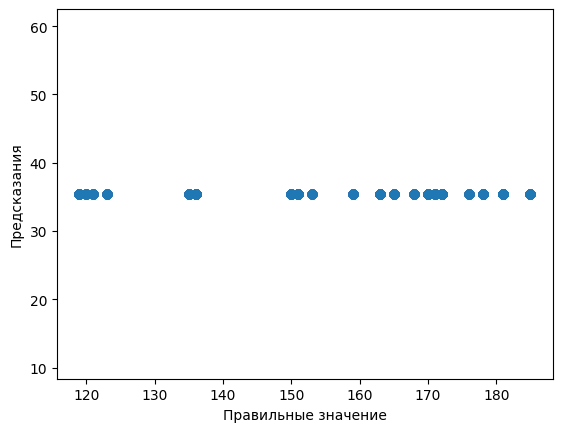

1324/1324 [==============================] - 17s 13ms/step - loss: 119.4070 - mae: 119.4070 - val_loss: 115.2443 - val_mae: 115.2443 - lr: 1.0000e-04
Epoch 6/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 114.508 очков это 73.221% от общей выборки в 2623 игры


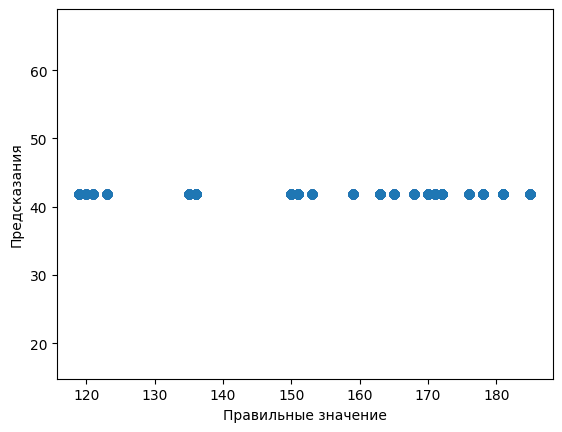

1324/1324 [==============================] - 18s 13ms/step - loss: 112.8510 - mae: 112.8510 - val_loss: 108.8125 - val_mae: 108.8125 - lr: 1.0000e-04
Epoch 7/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 108.176 очков это 69.172% от общей выборки в 2623 игры


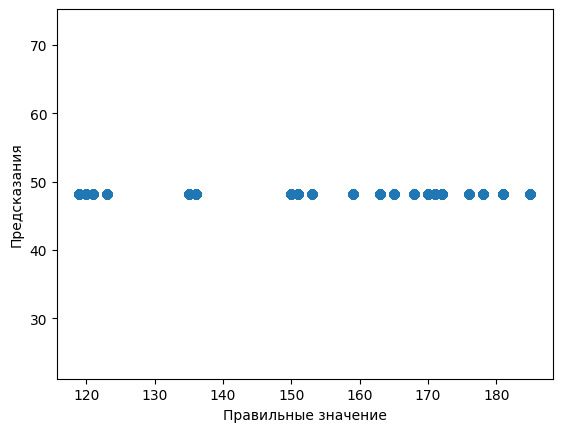

1324/1324 [==============================] - 17s 12ms/step - loss: 106.5398 - mae: 106.5398 - val_loss: 102.4872 - val_mae: 102.4872 - lr: 1.0000e-04
Epoch 8/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 101.858 очков это 65.132% от общей выборки в 2623 игры


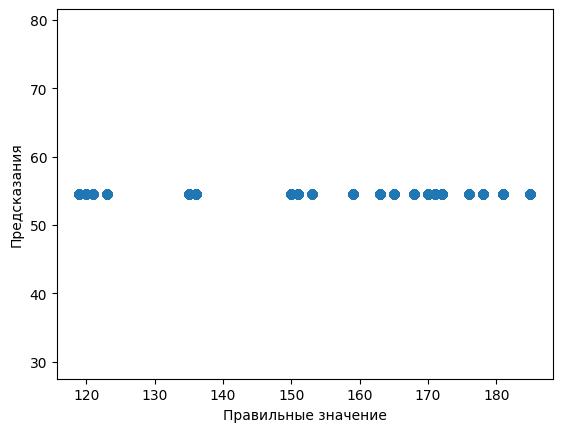

1324/1324 [==============================] - 16s 12ms/step - loss: 100.1711 - mae: 100.1711 - val_loss: 96.1763 - val_mae: 96.1763 - lr: 1.0000e-04
Epoch 9/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 95.553 очков это 61.101% от общей выборки в 2623 игры


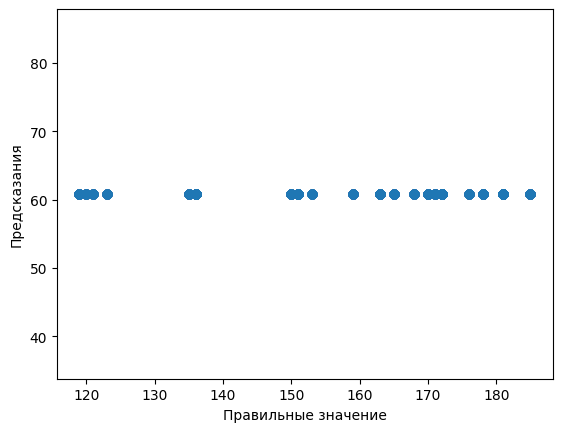

1324/1324 [==============================] - 18s 14ms/step - loss: 93.9163 - mae: 93.9163 - val_loss: 89.8782 - val_mae: 89.8782 - lr: 1.0000e-04
Epoch 10/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 89.254 очков это 57.073% от общей выборки в 2623 игры


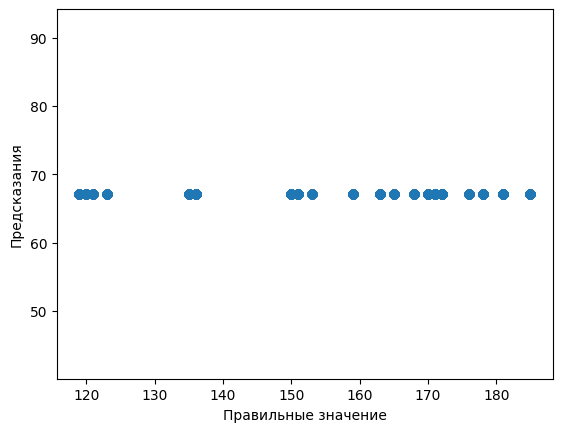

1324/1324 [==============================] - 22s 16ms/step - loss: 87.6971 - mae: 87.6971 - val_loss: 83.5861 - val_mae: 83.5861 - lr: 1.0000e-04
Epoch 11/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 82.721 очков это 52.895% от общей выборки в 2623 игры


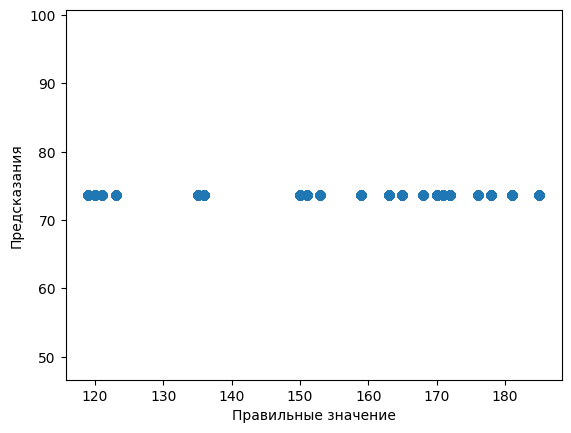

1324/1324 [==============================] - 18s 14ms/step - loss: 81.4701 - mae: 81.4701 - val_loss: 77.0601 - val_mae: 77.0601 - lr: 1.0000e-04
Epoch 12/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 76.246 очков это 48.754% от общей выборки в 2623 игры


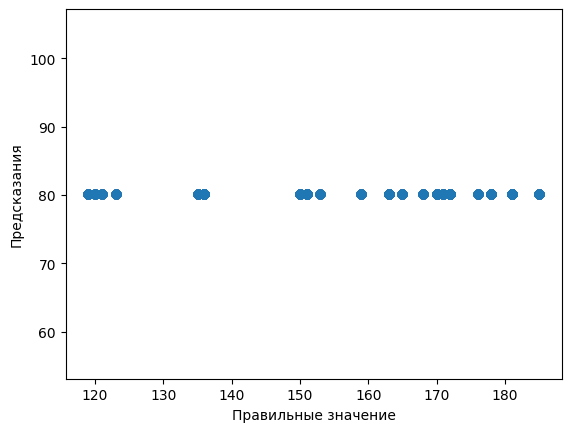

1324/1324 [==============================] - 20s 15ms/step - loss: 74.9505 - mae: 74.9505 - val_loss: 70.5913 - val_mae: 70.5913 - lr: 1.0000e-04
Epoch 13/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 69.828 очков это 44.650% от общей выборки в 2623 игры


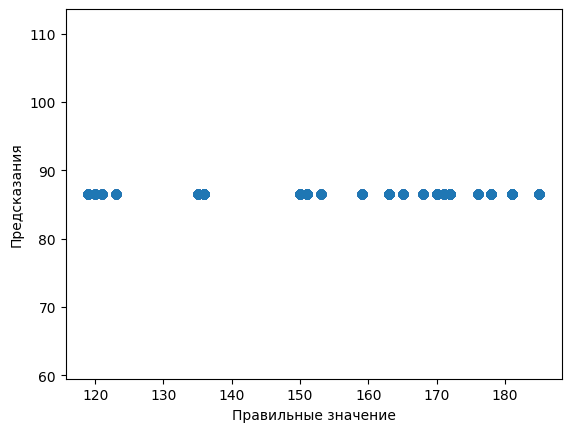

1324/1324 [==============================] - 19s 14ms/step - loss: 68.6659 - mae: 68.6659 - val_loss: 64.1801 - val_mae: 64.1801 - lr: 1.0000e-04
Epoch 14/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 63.023 очков это 40.300% от общей выборки в 2623 игры


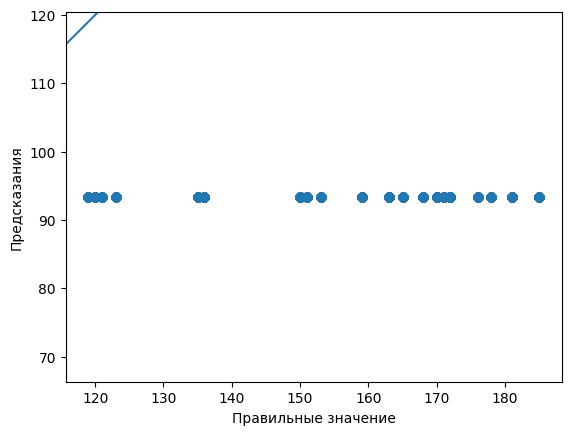

1324/1324 [==============================] - 18s 13ms/step - loss: 62.2205 - mae: 62.2205 - val_loss: 57.3830 - val_mae: 57.3830 - lr: 1.0000e-04
Epoch 15/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 56.500 очков это 36.128% от общей выборки в 2623 игры


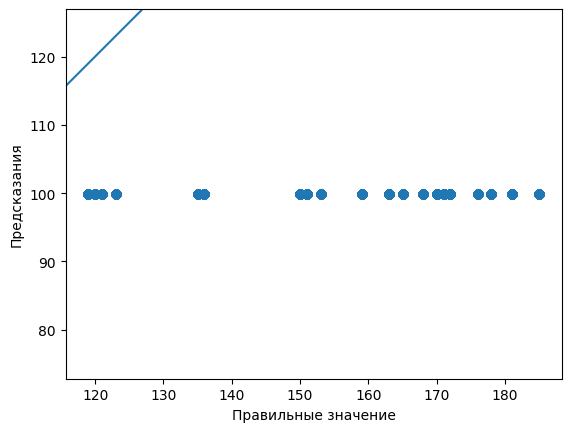

1324/1324 [==============================] - 17s 13ms/step - loss: 55.7554 - mae: 55.7554 - val_loss: 50.8666 - val_mae: 50.8666 - lr: 1.0000e-04
Epoch 16/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 50.070 очков это 32.017% от общей выборки в 2623 игры


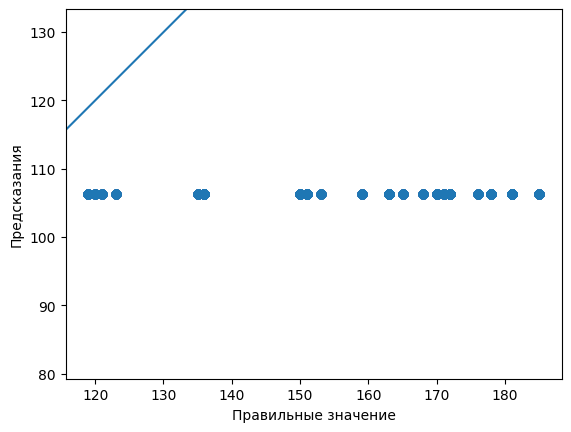

1324/1324 [==============================] - 18s 13ms/step - loss: 49.7221 - mae: 49.7221 - val_loss: 44.4436 - val_mae: 44.4436 - lr: 1.0000e-04
Epoch 17/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 43.648 очков это 27.910% от общей выборки в 2623 игры


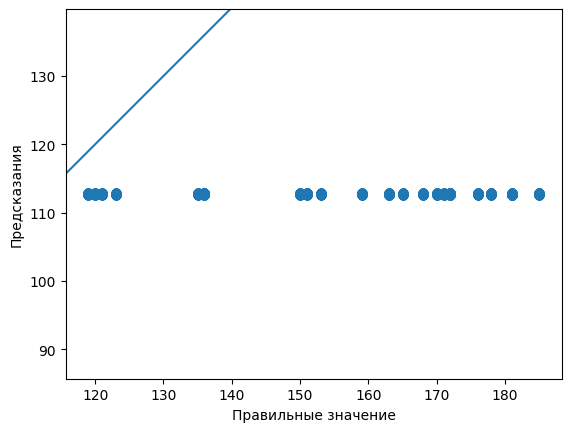

1324/1324 [==============================] - 17s 13ms/step - loss: 43.9653 - mae: 43.9653 - val_loss: 38.1690 - val_mae: 38.1690 - lr: 1.0000e-04
Epoch 18/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 37.156 очков это 23.759% от общей выборки в 2623 игры


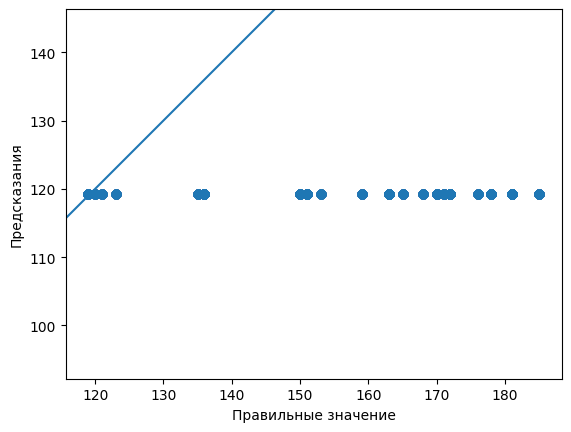

1324/1324 [==============================] - 19s 14ms/step - loss: 38.3206 - mae: 38.3206 - val_loss: 32.0389 - val_mae: 32.0389 - lr: 1.0000e-04
Epoch 19/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 32.566 очков это 20.824% от общей выборки в 2623 игры


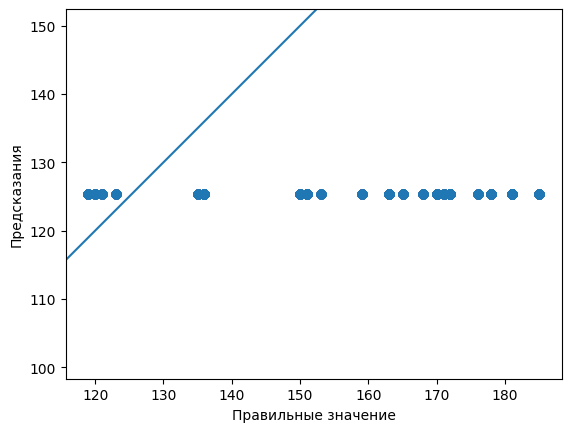

1324/1324 [==============================] - 25s 19ms/step - loss: 33.5126 - mae: 33.5126 - val_loss: 26.6502 - val_mae: 26.6502 - lr: 1.0000e-04
Epoch 20/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 28.650 очков это 18.320% от общей выборки в 2623 игры


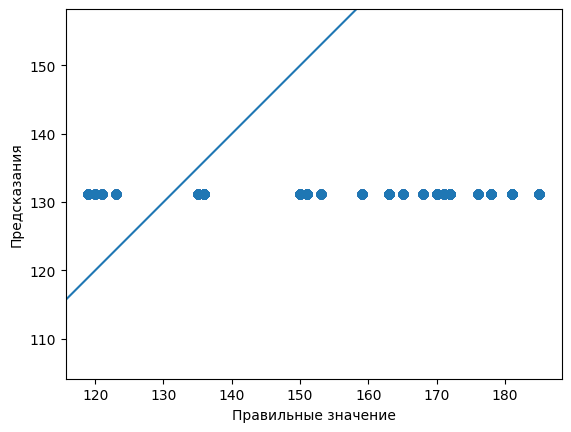

1324/1324 [==============================] - 17s 13ms/step - loss: 29.4281 - mae: 29.4281 - val_loss: 22.5518 - val_mae: 22.5518 - lr: 1.0000e-04
Epoch 21/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 25.242 очков это 16.140% от общей выборки в 2623 игры


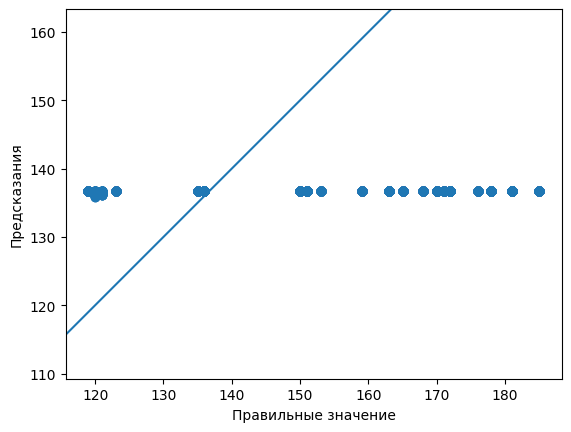

1324/1324 [==============================] - 18s 14ms/step - loss: 26.0609 - mae: 26.0609 - val_loss: 19.4162 - val_mae: 19.4162 - lr: 1.0000e-04
Epoch 22/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 22.664 очков это 14.492% от общей выборки в 2623 игры


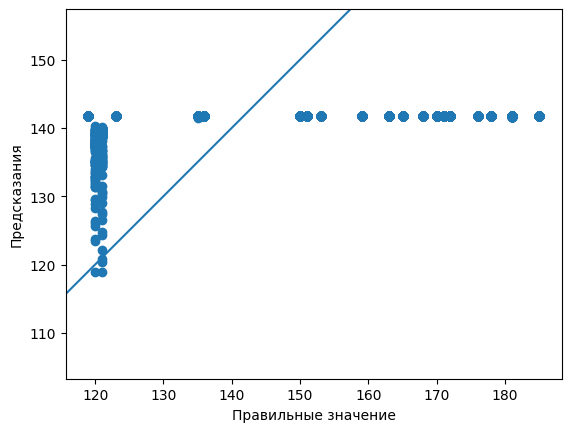

1324/1324 [==============================] - 18s 14ms/step - loss: 23.1305 - mae: 23.1305 - val_loss: 18.2652 - val_mae: 18.2652 - lr: 1.0000e-04
Epoch 23/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 18.465 очков это 11.807% от общей выборки в 2623 игры


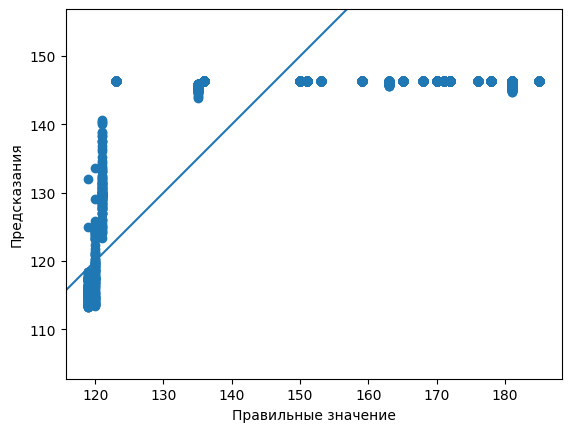

1324/1324 [==============================] - 18s 14ms/step - loss: 20.6354 - mae: 20.6354 - val_loss: 17.3833 - val_mae: 17.3833 - lr: 1.0000e-04
Epoch 24/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 17.347 очков это 11.092% от общей выборки в 2623 игры


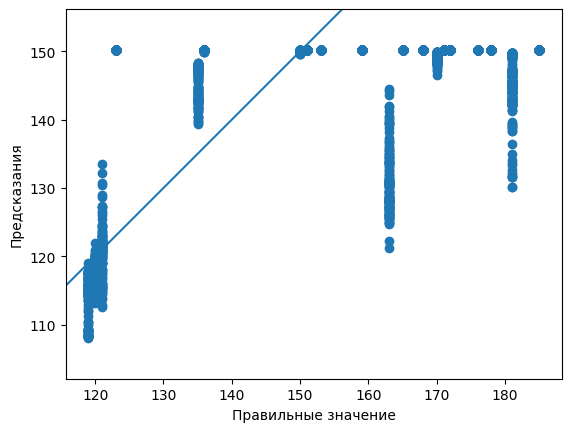

1324/1324 [==============================] - 19s 14ms/step - loss: 18.7585 - mae: 18.7585 - val_loss: 17.6104 - val_mae: 17.6104 - lr: 1.0000e-04
Epoch 25/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 16.824 очков это 10.758% от общей выборки в 2623 игры


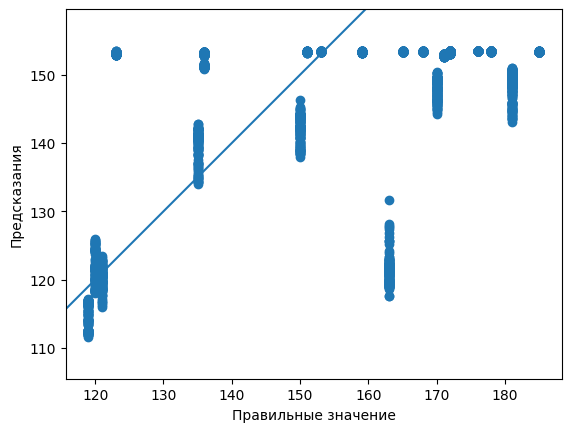

1324/1324 [==============================] - 18s 14ms/step - loss: 17.5447 - mae: 17.5447 - val_loss: 16.5706 - val_mae: 16.5706 - lr: 1.0000e-04
Epoch 26/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 15.195 очков это 9.716% от общей выборки в 2623 игры


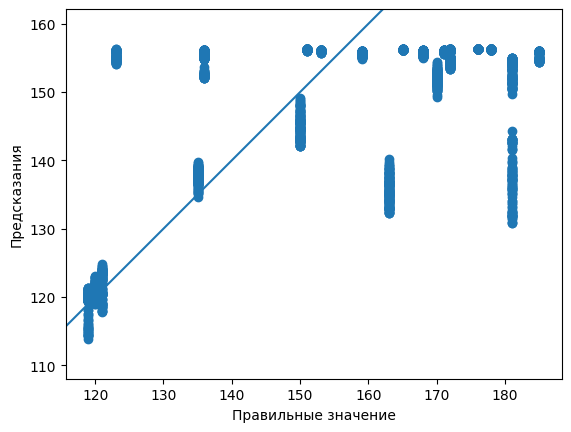

1324/1324 [==============================] - 21s 16ms/step - loss: 16.7153 - mae: 16.7153 - val_loss: 16.3600 - val_mae: 16.3600 - lr: 1.0000e-04
Epoch 27/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 15.651 очков это 10.008% от общей выборки в 2623 игры


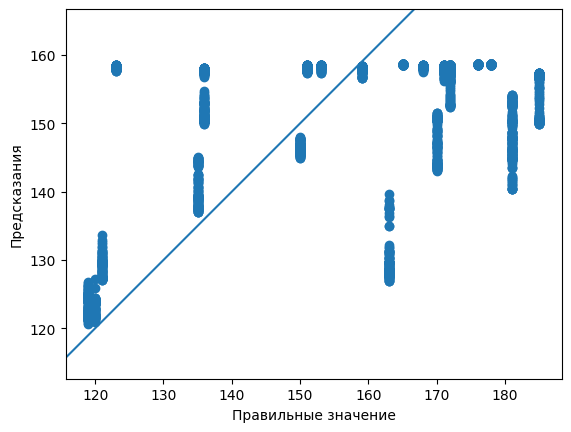

1324/1324 [==============================] - 21s 16ms/step - loss: 15.9632 - mae: 15.9632 - val_loss: 16.3854 - val_mae: 16.3854 - lr: 1.0000e-04
Epoch 28/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 15.201 очков это 9.720% от общей выборки в 2623 игры


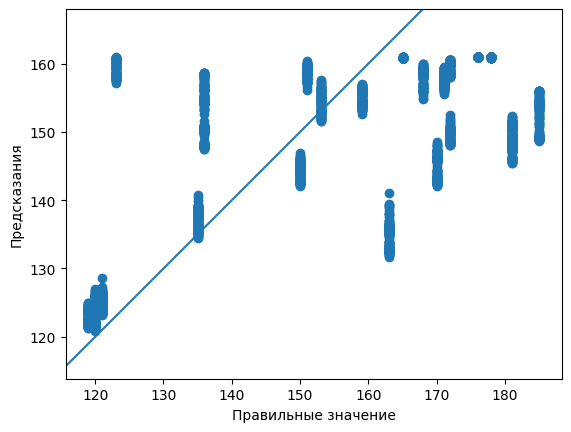

1324/1324 [==============================] - 20s 15ms/step - loss: 15.3937 - mae: 15.3937 - val_loss: 16.0818 - val_mae: 16.0818 - lr: 1.0000e-04
Epoch 29/30
82/82 [==============================] - 0s 4ms/step
Среднаяя абслолютная ошибка 14.739 очков это 9.425% от общей выборки в 2623 игры


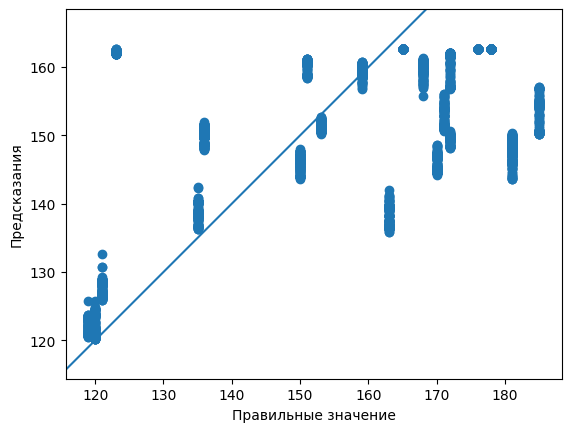

1324/1324 [==============================] - 20s 15ms/step - loss: 15.0490 - mae: 15.0490 - val_loss: 16.1248 - val_mae: 16.1248 - lr: 1.0000e-04
Epoch 30/30
82/82 [==============================] - 0s 3ms/step
Среднаяя абслолютная ошибка 15.305 очков это 9.787% от общей выборки в 2623 игры


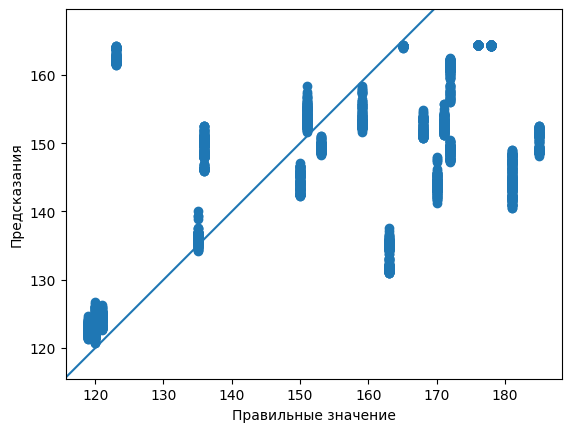


Epoch 30: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1324/1324 [==============================] - 20s 15ms/step - loss: 14.7693 - mae: 14.7693 - val_loss: 16.0872 - val_mae: 16.0872 - lr: 1.0000e-04


In [ ]:
history = model.fit((x_train, x_train_txt),
                    y_train,
                    epochs = 30,
                    validation_split = 0.15,
                    verbose = 1,
                    shuffle = True,
                    callbacks = [callback, reduceLROnPlateau]
                    )

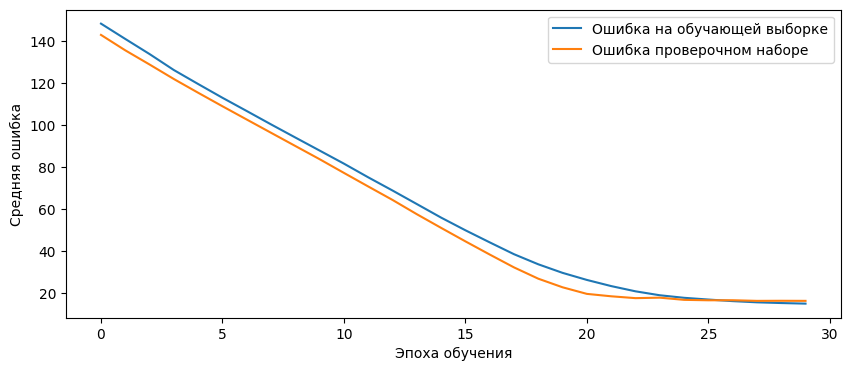

In [ ]:
plt.figure(figsize = (10, 4))
plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], label='Ошибка проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

В результате удалось добиться средней абсолютной ошибки ошибки в 15.3 очка на тестовом наборе